# Annexes 

## Table des matières

* [Codes supplémentaires](#section1)
    * [Multi-Threading](#section11)
    * [Travail sur le poids des fichiers](#section12)
        * [Zip](#section121)
        * [Partition des fichiers](#section122)
    * [Comparaison des régressions en fonction de la densité](#section2)
        * [Reprise des données](#section21)
        * [Résultats comparatifs](#section22)



## Codes supplémentaires<a class="anchor" id="section1"></a>

Dans cette section seront regroupés tous les codes qui ont été faits, en partie ou totalement, mais qui ne sont finalement pas intégrés au projet final. Nous les avons mis car ils sont potentiellement intéressants: ils explorent d'autre méthodes par exemple, et restent en lien avec le projet, donc pourraient servir à l'avenir dans des projets similaires. Les deux premières parties ne contiennent que les fonctions la dernière partie contient aussi l'importation des modules nécessaires et une rapide présentation des résultats

### Multi-Threading <a class="anchor" id="section11"></a>

Lors de nos tentatives de récupération des données via l'API Piste, une méthode envisagée fût de récupérer les fichiers sur des pages de de taille 1, car cela semblait fonctionner au delà du 10001e éléments. Ainsi pour pallier les contraintes de temps du projet nous avons codé de quoi faire simultanément les récupération de données en multi-threading. 

L'idée est donc de calculer le nombre de pages restantes pour la requête souhaitée, puis en donnant le nombre de threads souhaités produire le même nombre de fonctions. Ces fonctions récupéreront les données sur des plages de pages de tailles similaires, les plages correspondent environ au ratio de pages restantes par rapport aux nombres de fonctions. 

In [ ]:
def remaining_page_number(file_name):
    '''
    Calcule le nombre de pages restantes à récupérer en comparant le nombre total de résultats et la progression sauvegardée dans un fichier spécifique.

    :param file_name: Nom du fichier JSON utilisé pour sauvegarder la progression (sans l'extension).
    :return: Le nombre de pages restantes à récupérer à partir de la progression sauvegardée.
    '''
    api_host = API_HOST+"/search"
    client = get_client()
    response = client.post(api_host, json=code_api).json()
    total_results = response.get("totalResultNumber", 0)
    file_name = str(file_name)+".json"
    try:
        # Charger les données existantes si le fichier existe
        with open(file_name, "r", encoding="utf-8") as file:
            existing_data = json.load(file)
            if not isinstance(existing_data, dict):
                raise ValueError("Le fichier de sauvegarde n'est pas correctement structuré.")
            start_page = existing_data.get("current_page", 1)
    except (FileNotFoundError, ValueError):
        start_page = 0
    remaining_page = total_results-start_page
    return remaining_page    

In [ ]:
def collect_all_results_between(api_host, code, page_to_start, page_to_end, thread_number):
    '''
    Récupère les résultats d'une requête API sur une plage spécifique de pages.

    :param api_host: Adresse du serveur où envoyer la requête avec le endpoint correspondant.
    :param code: Code de la requête en json
    :param page_to_start: Numéro de la première page à récupérer dans la plage.
    :param page_to_end: Numéro de la dernière page à récupérer dans la plage.
    :param thread_number: Numéro du thread utilisé pour différencier les fichiers de sauvegarde.
    :return: Aucun retour direct, les résultats sont sauvegardés dans un fichier JSON.
    '''

    client = get_client()
    expires_in = 55*60
    token_expiry = datetime.now() + timedelta(seconds=expires_in)

    file_name = str(thread_number)+"results.json"


    all_results = []

    for page_number in range(page_to_start, page_to_end + 1):
        # Vérifier si le token doit être renouvelé
        if datetime.now() >= token_expiry:
            print("Renouvellement du client OAuth...")
            client = get_client()
            token_expiry = datetime.now() + timedelta(seconds=expires_in)

        print(f"Récupération de la page {page_number}/{page_to_end - page_to_start +1}...")
        code["recherche"]["pageNumber"] = page_number
        response = client.post(api_host, json=code).json()
        page_results = response.get("results", [])

        if response.get("error") == 503:
            print(response)
            break

        if page_number % 10 == 0: 
            print(response)

        # Ajouter les résultats de la page courante
        all_results.extend(page_results)

        # Sauvegarder les résultats toutes les 20 pages ou à la dernière page
        if page_number % 20 == 0 or page_number == page_to_end:
            print(f"Ajout des pages jusqu'à la page {page_number} dans {file_name}...")
            save_results_to_file(all_results, file_name, page_number)

            # Réinitialiser la liste des résultats sauvegardés
            all_results = []


In [ ]:
def generate_functions(n, file_name):
        '''
        Génère un ensemble de fonctions pour récupérer des pages de résultats en parallèle.

        :param n: Nombre de threads ou de fonctions à générer.
        :param file_name: Nom du fichier JSON utilisé pour sauvegarder la progression (sans l'extension).
        :return: Un dictionnaire contenant les fonctions générées, prêtes à être exécutées pour traiter une plage de pages.
        '''

        api_host = API_HOST+"/search"
        client = get_client()
        remaining_page = remaining_page_number(file_name)
        functions = {}
        file_name = str(file_name)+".json"
        response = client.post(API_HOST+"/search", json=code_api).json()
        total_results = response.get("totalResultNumber", 0)
        try:
            with open(file_name, "r", encoding="utf-8") as file:
                existing_data = json.load(file)
                if not isinstance(existing_data, dict):
                    raise ValueError("Le fichier de sauvegarde n'est pas correctement structuré.")
                start_page = existing_data.get("current_page", 1)
        except (FileNotFoundError, ValueError):
            start_page = 1

        page_state = [start_page, start_page]

        for i in range(1, n + 1):
            if i != n : 
                    page_to_end = [int(np.floor(remaining_page*i/n)+ page_state[1])]
            else : 
                    page_to_end = [total_results]

            thread_number = i

            def func_template(idx=i, start=page_state[0], end=page_to_end[0], thread_nbr= thread_number):
                collect_all_results_between(API_HOST+"/search", code_api, start, end, thread_nbr)

            page_state[0]= page_to_end[0] + 1
                
            functions[f"f_{i}"] = func_template
        return functions

In [ ]:
def functions_to_thread(n, file_name):
    '''
    Prépare une liste de fonctions générées avec leurs arguments pour une exécution dans des threads.

    :param n: Nombre de threads ou de fonctions à générer.
    :param file_name: Nom du fichier JSON utilisé pour sauvegarder la progression (sans l'extension).
    :return: Une liste de tuples contenant les fonctions générées, leurs arguments (liste vide), et leurs mots-clés (dictionnaire vide).
    '''

    generated_functions = generate_functions(n, file_name)
    functions = [(generated_functions[f"f_{i}"], [], {}) for i in range(1, n+1) ]
    return functions

In [ ]:
def run_in_threads(functions):
    '''
    Exécute un ensemble de fonctions dans des threads distincts.

    :param functions: Liste de tuples contenant les fonctions à exécuter, leurs arguments (sous forme de liste), et leurs mots-clés (sous forme de dictionnaire).
    :return: Aucun retour direct. Les threads sont lancés et exécutés, puis attendus jusqu'à leur complétion.
    '''

    threads = []

    for func, args, kwargs in functions:
        thread = Thread(target=func, args=args, kwargs=kwargs)
        threads.append(thread)
        thread.start()

    # Attendre la fin de tous les threads
    for thread in threads:
        thread.join()

### Travail sur le poids des fichiers <a class="anchor" id="section12"></a>

Lors de la récolte des données de Légifrance nous avons fait face à des fichiers très lourds, parfois proche du giga, dès lors deux choses ont été entreprises plus ou moins partiellement. 

#### Zip <a class="anchor" id="section121"></a>

La première méthode et la plus classique consistait en une compression des fichiers au format Zip, ce qui se révéla très peu efficace car les fichiers json sont déjà bien compressés par essence. 

In [ ]:
def zipper_fichier(fichier, zip_nom):
    """
    Crée un fichier ZIP contenant le fichier spécifié et supprime le fichier d'origine

    :param fichier: Chemin du fichier à zipper.
    :param zip_nom: Nom du fichier ZIP de sortie.
    """
    with zipfile.ZipFile(zip_nom, 'w') as zipf:
        zipf.write(fichier, arcname=fichier.split('/')[-1]) 
        os.remove(fichier)

In [ ]:
def extraire_json_du_zip(fichier_zip, fichier_sortie):
    """
    Extrait un fichier JSON contenu dans une archive ZIP et le sauvegarde.

    :param fichier_zip: Chemin de l'archive ZIP contenant le fichier JSON.
    :param fichier_sortie: Chemin du fichier JSON extrait.
    """
    with zipfile.ZipFile(fichier_zip, 'r') as zipf:
        json_fichier = zipf.namelist()[0]  
        with zipf.open(json_fichier) as file:
            data = json.load(file)
        with open(fichier_sortie, 'w', encoding='utf-8') as json_file:
            json.dump(data, json_file, indent=4)

##### Partition des fichiers <a class="anchor" id="section122"></a>

La seconde méthode est restée au stade de brouillon mais consistait en une partition des fichier json afin de pouvoir les envoyer segmentés sur github avant de les reconstruire au moment de l'exécution des fonctions.

In [ ]:
def segmenter_json_par_parties(fichier_json, dossier_sortie, nombre_parties):
    """
    Segmente un fichier JSON en un nombre spécifique de parties.

    :param fichier_json: Chemin du fichier JSON à segmenter.
    :param dossier_sortie: Dossier où les segments seront sauvegardés.
    :param nombre_parties: Nombre de parties dans lesquelles le fichier sera segmenté.
    """
    # Lire le contenu du fichier JSON
    with open(fichier_json, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Calculer la taille approximative de chaque partie
    taille_segment = math.ceil(len(data) / nombre_parties)

    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(dossier_sortie, exist_ok=True)

    # Segmenter les données
    for i in range(0, len(data), taille_segment):
        segment = data[i:i + taille_segment]
        segment_path = os.path.join(dossier_sortie, f'segment_{i // taille_segment + 1}.json')
        
        # Écrire chaque segment dans un fichier
        with open(segment_path, 'w', encoding='utf-8') as segment_file:
            json.dump(segment, segment_file, indent=4)
    
    print(f"Fichier JSON segmenté en {nombre_parties} parties dans le dossier '{dossier_sortie}'.")


In [ ]:
def assembler_json(dossier_segments, fichier_sortie):
    """
    Assemble plusieurs fichiers JSON en un seul fichier et supprime les segments.

    :param dossier_segments: Dossier contenant les segments JSON.
    :param fichier_sortie: Chemin du fichier JSON de sortie.
    """
    fichiers = sorted(os.listdir(dossier_segments))  # Trier les segments par nom
    data_combinee = []

    for fichier in fichiers:
        segment_path = os.path.join(dossier_segments, fichier)
        with open(segment_path, 'r', encoding='utf-8') as segment_file:
            data_combinee.extend(json.load(segment_file))

    # Écrire les données combinées dans un seul fichier JSON
    with open(fichier_sortie, 'w', encoding='utf-8') as output_file:
        json.dump(data_combinee, output_file, indent=4)
    
    print(f"Segments JSON assemblés dans '{fichier_sortie}', et les segments supprimés.")

## Comparaison des régressions en fonction de la densité <a class="anchor" id="section2"></a>

Dans cette partie, nous nous intéressons à examiner si les relations entre les variables (taux de pauvreté, nombre d'articles) et le taux (exprimé en /10 000) diffèrent en fonction de la densité de population des départements, en comparant les départements à forte densité selon un seuil arbitraire.

#### Reprise des données <a class="anchor" id="section21"></a>

In [ ]:
import s3fs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels import PanelOLS
from scripts.visualisation import filter_keyword
import statsmodels.api as sm

# Information d'accès au cloud MinIO (Bucket de Anh Linh)
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "anhlinh"

In [10]:
# Récupération de la base de données
FILE_PATH_S3_LODA = f"{MY_BUCKET}/diffusion/df_loda.csv"
with fs.open(FILE_PATH_S3_LODA, "rb") as file_in_loda:
    df_loda = pd.read_csv(file_in_loda)

FILE_PATH_S3_DEP = f"{MY_BUCKET}/diffusion/df_indicateurs_dep.csv"
with fs.open(FILE_PATH_S3_DEP, "rb") as file_in_dep:
    df_indicateurs_dep = pd.read_csv(file_in_dep)

FILE_PATH_S3_NAT = f"{MY_BUCKET}/diffusion/df_indicateurs_nat.csv"
with fs.open(FILE_PATH_S3_NAT, "rb") as file_in_nat:
    df_indicateurs_nat = pd.read_csv(file_in_nat)

In [11]:
def mise_en_forme_reg(keyword, indicateur):
    '''
    Prépare un DataFrame structuré pour effectuer une analyse de régression.

    Args:
    keyword (str): Mot-clé utilisé pour filtrer les articles dans le DataFrame `df_loda`.
    indicateur (str): Nom de l'indicateur de criminalité choisi.
    
    Returns: Un DataFrame contenant les données fusionnées et prêtes pour une analyse de régression.
    '''
    # Préparation de LODA
    df_loda_reg = df_loda.drop([ "Unnamed: 0", "ID", "Date", "Nature", "Etat", "Origine", "Date Publication", "Mois"], axis = 1)
    df_loda_filtre = filter_keyword(df_loda_reg,fr"\b{keyword}s?\b")
    df_loda_reg_filtre = df_loda_filtre.groupby("Année").size().reset_index(name="Nombre d'articles")
    
    # Préparation du taux de pauvreté 
    df_indicateurs_nat.head()
    df_indicateurs_nat_reg = df_indicateurs_nat.loc[: ,["Année", "Taux de pauvreté (%)"]]
    df_pauvrete_percent = df_indicateurs_nat_reg.drop_duplicates()

    # Préparation des autres régresseurs et filtrage sur l'indicateur de criminalité choisi
    df_indicateurs_reg = df_indicateurs_dep.drop([ "Unnamed: 0", "Superficie (km2)", "Nombre" , "Département"], axis = 1)
    df_indicateurs_reg = df_indicateurs_reg[df_indicateurs_reg["Indicateur"] == indicateur]

    df_pauvrete_loda_nbr= pd.merge(df_pauvrete_percent, df_loda_reg_filtre, on="Année", how="outer")
    df_reg =pd.merge(df_pauvrete_loda_nbr, df_indicateurs_reg, on = "Année", how = "outer")

    df_reg["Nombre d'articles"] = df_reg["Nombre d'articles"].fillna(0) # On remplace les valeurs manquante par 0
    df_reg = df_reg.drop(["Indicateur"], axis = 1) # On se débarasse de la colonne 'Indicateur' sur laquelle on ne régresse pas
    df_reg = df_reg.set_index(['Nom Département', 'Année']) # On met en index les colonnes qui indices nos variables

    return(df_reg)

#### Résultats comparatifs <a class="anchor" id="section22"></a>

La fonction regression_divisée implémentée ci-dessous effectue deux régressions en fonction des catégories de densité définies par un seuil arbitrairement choisis (par défaut 500 habitants par km² pour avoir suffisamment de données pour la régression à forte densité).

In [ ]:
def regression_divisée(df_reg, seuil_densite=500):
    """
    Cette fonction effectue des régressions séparées en fonction des catégories de densité
    définies par un seuil fixe (par défaut 5000 habitants par km²),
    puis visualise les résultats.

    Paramètres :
    df_reg : DataFrame
        Le DataFrame contenant les données avec la colonne 'Densité' et les autres variables nécessaires.
    seuil_densite : int, optionnel
        Le seuil de densité (en habitants par km²) pour séparer les départements en 'Faible' et 'Forte' densité.

    Retour :
    None
    """
    # Création des catégories de densité
    df_reg['Densité_cat'] = df_reg['Densité'].apply(
        lambda x: 'Forte' if x > seuil_densite else 'Faible'
    )

    # Régressions séparées pour chaque catégorie
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    categories = ['Faible', 'Forte']

    for i, cat in enumerate(categories):
        # Filtrer les données pour chaque catégorie
        df_temp = df_reg[df_reg['Densité_cat'] == cat]
        
        # Régression
        y_cat = df_temp['Taux (/10 000)']
        X_cat = df_temp[["Taux de pauvreté (%)", "Nombre d'articles", "Population", "Densité"]]
        X_cat = sm.add_constant(X_cat)
        
        model_cat = PanelOLS(y_cat, X_cat)
        results_cat = model_cat.fit()
        print(f"\nRésultats pour les départements à densité {cat}:")
        print(results_cat.summary)
        
        # Visualisation
        sns.scatterplot(data=df_temp, x="Nombre d'articles", y='Taux (/10 000)', alpha=0.6, ax=axes[i], label='Observations')
        sns.lineplot(data=df_temp, x="Nombre d'articles", y=results_cat.predict().fitted_values, color='red', ax=axes[i], label='Prédictions')
        axes[i].set_title(f"Densité {cat}")
        axes[i].set_xlabel("Nombre d'articles")
        axes[i].set_ylabel("Taux (/10 000)")
        axes[i].grid(True)
        axes[i].legend()

    plt.tight_layout()
    plt.show()



Résultats pour les départements à densité Faible:
                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.4410
Estimator:                   PanelOLS   R-squared (Between):              0.5544
No. Observations:                2383   R-squared (Within):               0.3410
Date:                Sun, Dec 29 2024   R-squared (Overall):              0.4410
Time:                        20:31:00   Log-likelihood                  -1.4e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      469.06
Entities:                          89   P-value                           0.0000
Avg Obs:                       26.775   Distribution:                  F(4,2378)
Min Obs:                       7.0000                                           
Max Obs:                       27.000   F-statistic (robus

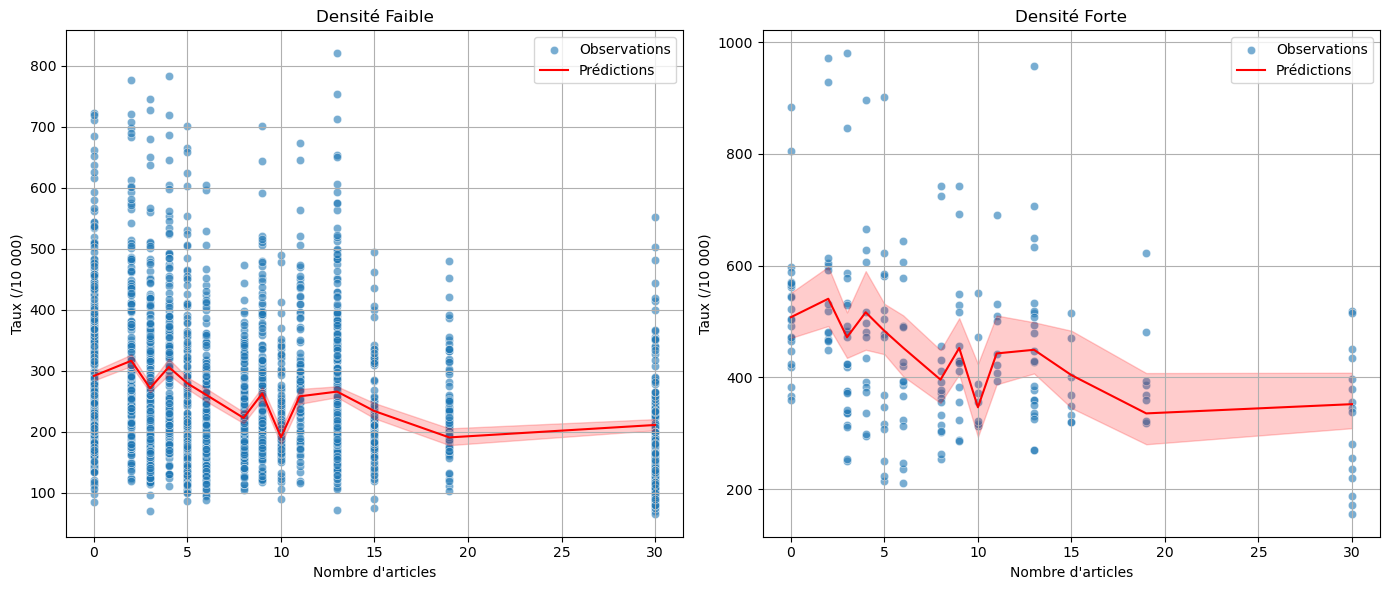

In [23]:
regression_divisée(mise_en_forme_reg('vol', 'Vols sans violence'))


Résultats pour les départements à densité Faible:
                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.2377
Estimator:                   PanelOLS   R-squared (Between):              0.1045
No. Observations:                2383   R-squared (Within):               0.2998
Date:                Sun, Dec 29 2024   R-squared (Overall):              0.2377
Time:                        20:31:25   Log-likelihood                   -8277.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      185.34
Entities:                          89   P-value                           0.0000
Avg Obs:                       26.775   Distribution:                  F(4,2378)
Min Obs:                       7.0000                                           
Max Obs:                       27.000   F-statistic (robus

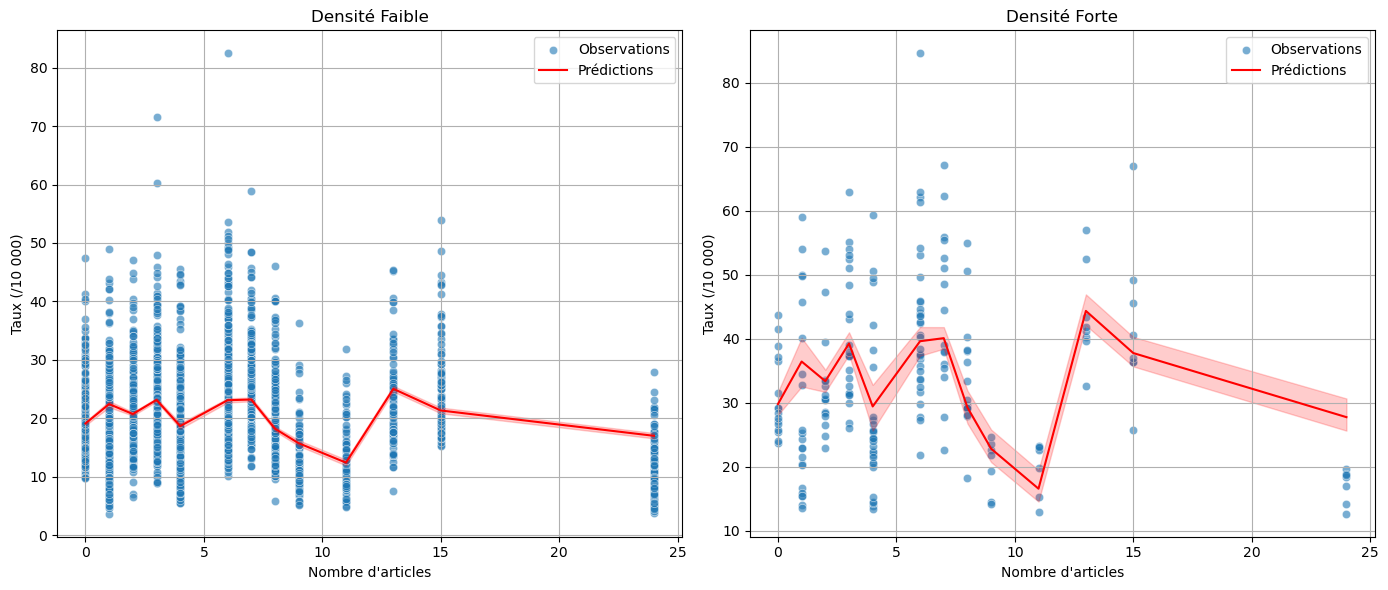

In [24]:
regression_divisée(mise_en_forme_reg('stupéfiant', 'Stupéfiants'))


Résultats pour les départements à densité Faible:
                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.5044
Estimator:                   PanelOLS   R-squared (Between):              0.6306
No. Observations:                2383   R-squared (Within):               0.0218
Date:                Sun, Dec 29 2024   R-squared (Overall):              0.5044
Time:                        20:31:55   Log-likelihood                   -7189.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      604.99
Entities:                          89   P-value                           0.0000
Avg Obs:                       26.775   Distribution:                  F(4,2378)
Min Obs:                       7.0000                                           
Max Obs:                       27.000   F-statistic (robus

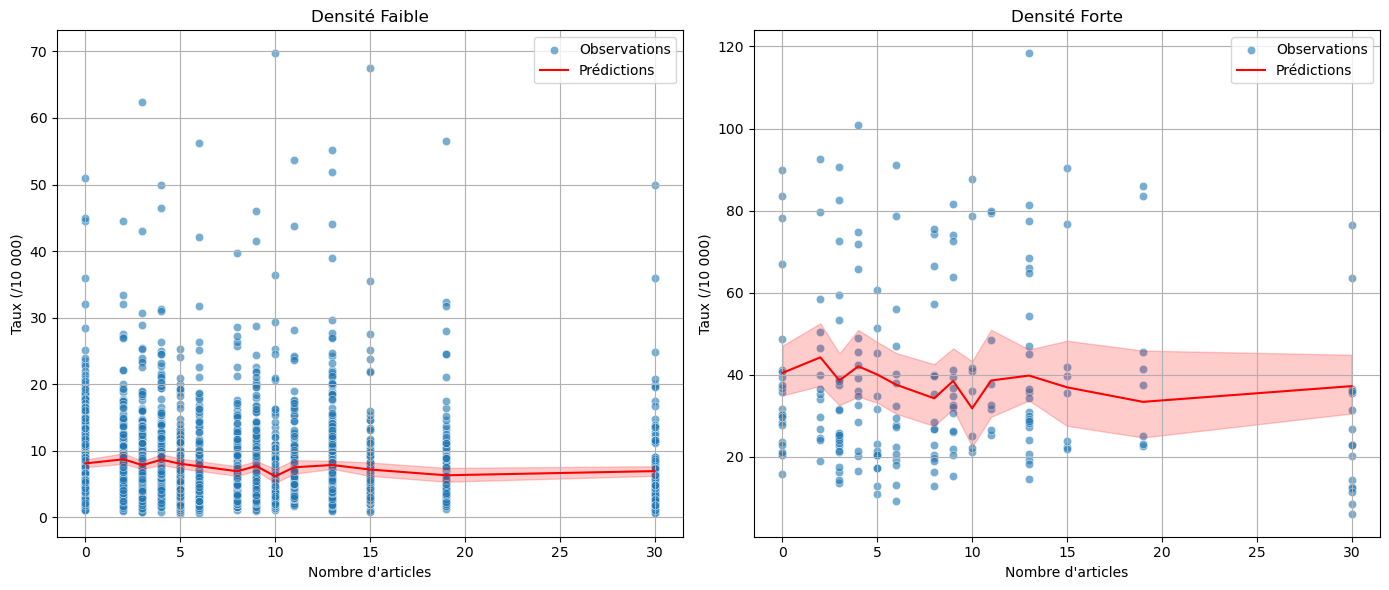

In [25]:
regression_divisée(mise_en_forme_reg('vol', 'Vols avec violence'))

Les résultats montrent que, dans tous les cas, les taux sont nettement plus élevés dans les départements à forte densité de population par rapport à ceux à faible densité. Cela suggère qu'en zones densément peuplées, les liens entre les différentes variables (comme le taux de pauvreté et le nombre d'articles) et le taux (/10 000) sont plus forts.